In [2]:
import gym
import seagul.envs
import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PPOModel, SwitchedPPOModel, SwitchedPPOModelActHold
from seagul.nn import MLP
#torch.set_default_dtype(torch.double)
dtype = np.float32


#seeds = [1]; load_paths =  ['./data2/drake_double/dynamic_step' + str(seed) for seed in seeds]
#load_paths =  ['./data2/sac/asdasdasd']
#load_paths = ['/home/sgillen/work/seagul/seagul/notebooks/switching2/data/drake_ppo2/25_ppo2_rand_2short4/']

load_paths = ['/home/sgillen/work/seagul/seagul/notebooks/switching2/data/debugdebug_2pol0/']
#load_paths = ['/home/sgillen/work/seagul/seagul/notebooks/switching2/data/drake_ppo2/25_ppo2_nws4/']
#seeds = [0]; load_paths = ['./data/drake_acro_final/warm_seed' + str(seed) for seed in seeds]
model, env, args, ws = load_workspace(load_paths[0])
#num_steps = ws['num_epochs']
#num_steps = 1000



/home/sgillen/work/seagul/seagul/envs/__init__.py:88: UserWarning: Warning, registering environments for rllib failed!
  warnings.warn("Warning, registering environments for rllib failed!")


seagul.rl.run_utils
seagul.rl.run_utils


/home/sgillen/work/seagul/seagul/rl/algos/__init__.py:9: UserWarning: tensorflow not installed, skipping symmetric ppo
  warnings.warn("tensorflow not installed, skipping symmetric ppo")
/home/sgillen/work/external/underactuated/src/underactuated/__init__.py:1: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459

  from .meshcat_rigid_body_visualizer import MeshcatRigidBodyVisualizer


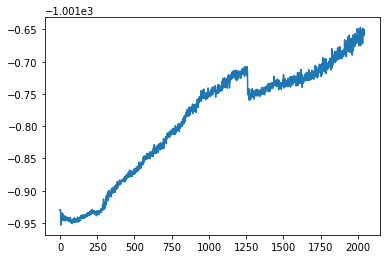

In [21]:
plt.plot(ws['raw_rew_hist'])

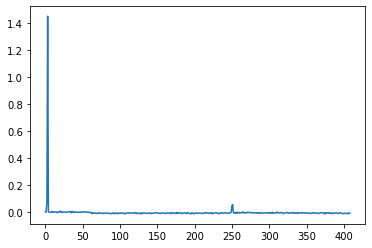

In [22]:
plt.plot(ws['pol_loss_hist'])

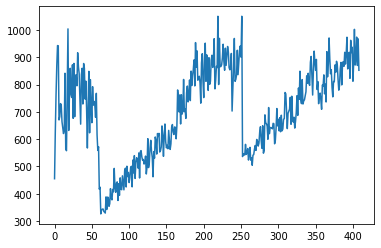

In [23]:
plt.plot(ws['val_loss_hist'])

In [36]:
#torch.save(model.value_fn, open('./warm/ppo2_warm_val','wb'))
#torch.save(model.policy, open('./warm/ppo2_warm_pol','wb'))

In [37]:
#model.value_fn.state_dict()

In [38]:
from seagul.nn import DummyNet

# Acrobot
#load_path = './data/drake_acro4/seed7'
load_path = load_paths[0]
model, env, args, ws = load_workspace(load_path)
#model.policy = DummyNet(4,1,0,0,0)
model.env = env
myenv = env
#myenv.num_steps=1000
#myenv.max_t = 5


#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
logp_hist = np.zeros((myenv.num_steps, 1))
gate_mean = np.zeros((myenv.num_steps,1))

#model.action_var = 0
#model.action_var = 1
#model.gate_var = 0

#model.action_var = 0
obs = myenv.reset()

for i in range(myenv.num_steps):
        obs = torch.as_tensor(obs, dtype=torch.float32).reshape(1,-1)
        actions, _, _, logp = model.step(obs.flatten())
        #actions = actions.detach()
        actions = np.clip(actions, -25,25)
        #actions = np.zeros(1)
        #actions = np.array([10])
        #gate_mean[i,:] = model.gate_fn(torch.as_tensor(obs)).detach().numpy()
        #actions = np.zeros(1)
        #actions = np.clip(actions,-10, 10)
        obs, reward, done, _ = env.step(actions)   
    
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        try:
            logp_hist[i,:]   = logp.detach()
        except:
            logp_hist[i,:]   = logp
            
        #env.render()
        if done:
            break
            
            
gate_hist = [1 if p == 0.0 else 0 for p in logp_hist]

seagul.rl.run_utils
seagul.rl.run_utils


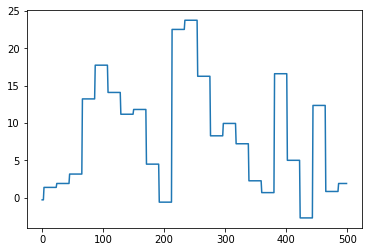

In [39]:
plt.plot(action_hist)

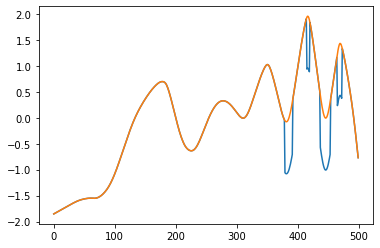

In [40]:
plt.plot(reward_hist)
plt.plot(-(np.cos(state_hist[:,0]) + np.cos(state_hist[:,0] + state_hist[:,1])))


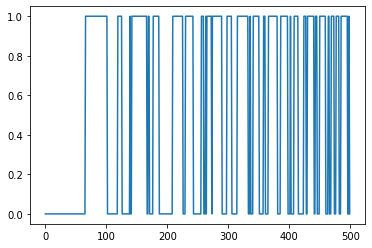

In [28]:
plt.plot(gate_hist)

In [15]:
env = gym.make('su_acro_drake-v0')

env.num_steps = 500

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #k = 
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
path_hist = np.zeros((env.num_steps,1))


obs = env.reset(init_vec = [.02,0,0,0]) 

import time
start = time.time()
for i in range(env.num_steps):
        if(pi - 0.2 < obs[0] < pi+ 0.2 and -0.5 < obs[1] < 0.5): #and abs(obs[2]) < 1 and abs(obs[3] < 1)):
            actions = np.clip(np.asarray(control(obs)), -25,25)
            path_hist[i] = 1
        else:
            actions, _, _, logp = model.step(torch.as_tensor(obs, dtype=torch.float32).reshape(1,-1))
            path_hist[i] = 0

        actions =  np.clip(actions, -25, 25)
        obs, reward, done, _ = env.step(actions)
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
       # if done:
       #     break
            
print("total", time.time() - start)

plt.plot(action_hist)
plt.title('action hist')

plt.figure()
plt.plot(path_hist)
plt.title('path hist')

plt.figure()
plt.plot(reward_hist)
plt.title('reward hist')

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta 1")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("theta 2")

plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta1 dot")

plt.figure()
plt.plot(state_hist[:,3])
plt.title("theta 2 dot ")

print(sum(reward_hist))

ValueError: shapes (1,4) and (1,4) not aligned: 4 (dim 1) != 1 (dim 0)